In [1]:
import os

root_dir = './dataset/KIT-ML/texts'
file_names = []

for i in range(0,3950,100):
    file_name = f'{i}'.zfill(5) +'.txt'
    text_path = os.path.join(root_dir,file_name)
    
    if os.path.isfile(text_path) == False:
        j = i
        while os.path.isfile(text_path) == False:
            j = j+1
            file_name = f'{j}'.zfill(5) +'.txt'
            text_path = os.path.join(root_dir,file_name)
        j = j-i
    file_names.append(file_name)
    
    with open(text_path) as file:
            print(f'{i+j}: {file.readline().split("#")[0]}')
    j = 0

1: A person is walking forwards.
100: A person walks forward.
200: Someone walks in a slight right curve
300: human walks in a quater circle counterclockwise
400: a person walks in a circle to he left
500: A human goes slowly about 1.5 meters forward.
600: A human performing a handspring
700: A persons walks forward fast.
800: A human walks a quarter circle clockwise
900: A human moves straight forward.
1000: A person walking forwards, then turning on the right foot and walking back.
1100: A person moves a little bit and then stands by
1200: A person goes approximately 2 meters forward.
1300: A person performs a punch with their right hand
1400: A person waves with the left hand.
1500: A person moves the left hand in front of the body in a half circle.
1600: A person walks forward
1700: A person stumbling to the left.
1800: the person is pushed to the left while walking forward
1900: A person makes four steps forward.
2000: a human walks and turns on the spot
2100: A persons crawls on 

In [2]:
len(file_names)

40

In [1]:
import options.option_transformer as option_trans
import sys
import clip
import torch
import numpy as np
import models.vqvae as vqvae
import models.t2m_trans as trans
import warnings
warnings.filterwarnings('ignore')

sys.argv = ['test']

args = option_trans.get_args_parser()

args.dataname = 'kit'
args.resume_pth = 'pretrained/VQVAE_KIT/net_best_fid.pth' # github의 closed_issue에서 pre-trained KIT 다운가능
args.resume_trans = 'pretrained/VQTransformer_KIT_fid_16head_1024dim_18layer_05/net_best_fid.pth'
args.down_t = 2
args.depth = 3
args.block_size = 51

net = vqvae.HumanVQVAE(args, ## use args to define different parameters in different quantizers
                       args.nb_code,
                       args.code_dim,
                       args.output_emb_width,
                       args.down_t,
                       args.stride_t,
                       args.width,
                       args.depth,
                       args.dilation_growth_rate)
print ('loading checkpoint from {}'.format(args.resume_pth))
ckpt = torch.load(args.resume_pth, map_location='cpu')
net.load_state_dict(ckpt['net'], strict=True)
net.eval()
net.cuda()

mean = torch.from_numpy(np.load('./checkpoints/kit/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/mean.npy')).cuda()
std = torch.from_numpy(np.load('./checkpoints/kit/VQVAEV3_CB1024_CMT_H1024_NRES3/meta/std.npy')).cuda()

with open(f'dataset/KIT-ML/texts/00001.txt') as f:
    text = f.readline()
text = [(text.split("#")[0]).split(".")[0]]

# 사전에 motion data를 net.encode()를 통해 인코딩 후 저장하는 과정 필요
motion_indices = torch.tensor(np.load('dataset/KIT-ML/VQVAE/00001.npy')).cuda()

decoded_pose = net.forward_decoder(motion_indices)

from utils.motion_process import recover_from_ric
decoded_xyz = recover_from_ric((decoded_pose*std+mean).float(), 21)
decoded_xyz = decoded_xyz.reshape(1, -1, 21, 3)

org_xyz = np.load(f'dataset/KIT-ML/new_joints/00001.npy')
org_xyz = org_xyz.reshape(1, -1, org_xyz.shape[1], org_xyz.shape[2])

import visualization.plot_3d_global as plot_3d
pose_vis = plot_3d.draw_to_batch(decoded_xyz.detach().cpu().numpy(), text, ['decoded_motion.gif'])
pose_vis = plot_3d.draw_to_batch(org_xyz, text, ['original_motion.gif'])

loading checkpoint from pretrained/VQVAE_KIT/net_best_fid.pth


-----------------------------------------------------------------------
--------------------------- Decoded Motion ---------------------------



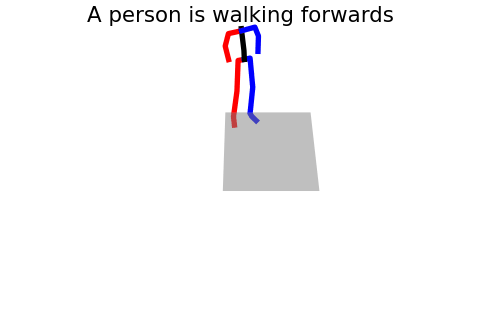

-----------------------------------------------------------------------
-----------------------------------------------------------------------


-----------------------------------------------------------------------
--------------------------- Original Motion ---------------------------



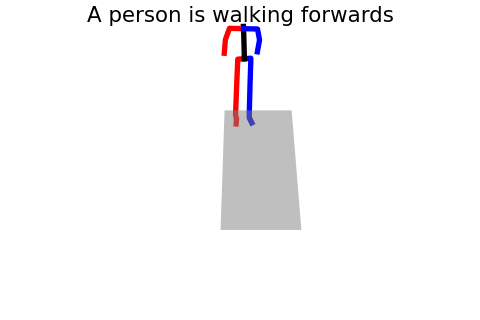

-----------------------------------------------------------------------
-----------------------------------------------------------------------


In [2]:
from IPython.display import HTML
import base64
b64_1 = base64.b64encode(open('decoded_motion.gif','rb').read()).decode('ascii')
b64_2 = base64.b64encode(open('original_motion.gif','rb').read()).decode('ascii')
print('-----------------------------------------------------------------------')
print('--------------------------- Decoded Motion ---------------------------')
display(HTML(f'<img src="data:image/gif;base64,{b64_1}" />'))
print('-----------------------------------------------------------------------')
print('-----------------------------------------------------------------------\n\n')
print('-----------------------------------------------------------------------')
print('--------------------------- Original Motion ---------------------------')
display(HTML(f'<img src="data:image/gif;base64,{b64_2}" />'))
print('-----------------------------------------------------------------------')
print('-----------------------------------------------------------------------')